Original and filtered lengths: 10889 8996
Removed elements: 1893
tensor(1686.9138, device='cuda:0')


/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


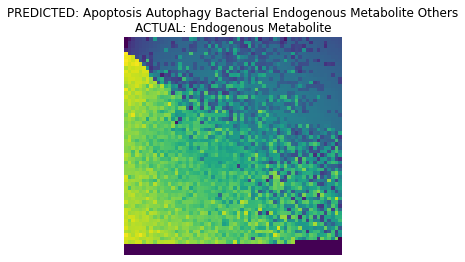

tensor(1692.7883, device='cuda:0')


/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


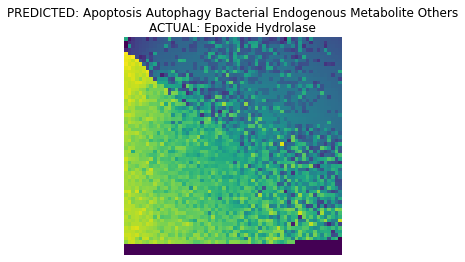

/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(1762.3334, device='cuda:0')


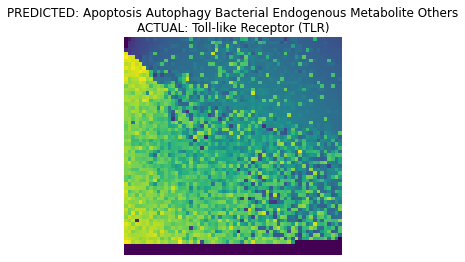

/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(1679.6510, device='cuda:0')


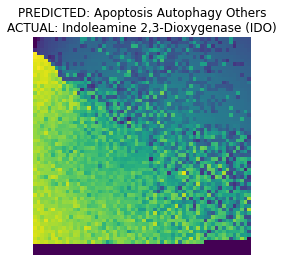

/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(1660.0784, device='cuda:0')


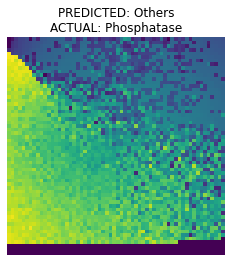

/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(1699.8942, device='cuda:0')


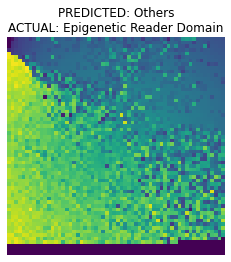

/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(1686.1060, device='cuda:0')


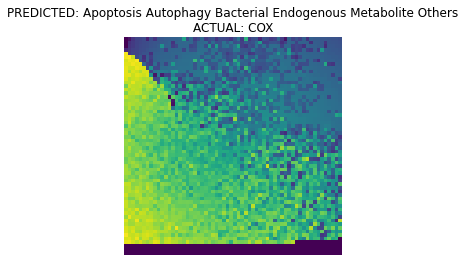

/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(1689.4628, device='cuda:0')


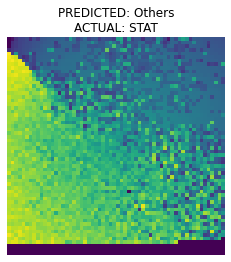

/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(1717.4628, device='cuda:0')


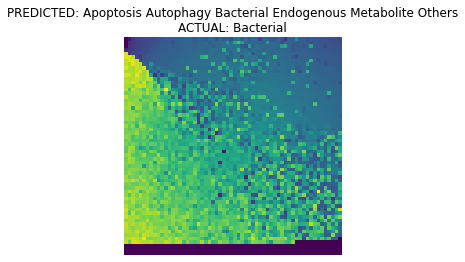

/raid/home/joshua/projects/drug_NN/src/dataset.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(1706.7217, device='cuda:0')


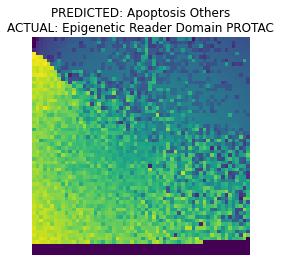

Precision Micro: 0.0606
Precision Macro: 0.0011
Recall Micro: 0.1818
Recall Macro: 0.0056
F1 Micro: 0.0909
F1 Macro: 0.0019
Average Loss: 0.6932


In [24]:
import models
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset import ImageDataset
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision')


# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = models.model(pretrained=False, requires_grad=False).to(device)
# load the model checkpoint
checkpoint = torch.load('../outputs/model.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

train_csv_original = pd.read_csv('../input/drug-classifier/drug_CNN/train_drugidx.csv')
train_csv = train_csv_original[~train_csv_original['Target_List'].str.contains('Others', case=False)] # Filter the categories to not include others
genres = train_csv.columns.values[2:]
print('Original and filtered lengths:', len(train_csv_original), len(train_csv))
print('Removed elements:', len(train_csv_original)-len(train_csv))

# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv, train=False, test=True
)
test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=False
)

# Initialize arrays to store true and predicted labels
true_labels = []
predicted_labels = []
# Initialize a list to store losses
losses = []

# Define the loss function
loss_function = torch.nn.BCEWithLogitsLoss()

for counter, data in enumerate(test_loader):
    image, target = data['image'].to(device), data['label'].to(device)
    print(torch.sum(image))
    # Forward pass
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu().numpy()
    if isinstance(outputs, np.ndarray):
        outputs_loss = torch.tensor(outputs).to(device).float()
    else:
        outputs_loss = outputs.float().to(device)
    
    if isinstance(target, np.ndarray):
        target = torch.tensor(target).to(device).float()
    else:
        target = target.float().to(device)
    
    # Compute the loss
    loss = loss_function(outputs_loss, target.float())  # Make sure target is a float tensor
    losses.append(loss.item())
    
    # Convert outputs to binary predictions
    predicted = (outputs > 0.004).astype(int)
    
    # Store predictions and true labels
    true_labels.append(target)
    predicted_labels.append(predicted)
    
    # Convert the predictions and targets to the correct format for metric calculation
    target_indices = np.where(target[0].cpu() == 1)[0]
    predicted_indices = np.where(predicted[0] == 1)[0]
    
    string_predicted = ' '.join(genres[predicted_indices])
    string_actual = ' '.join(genres[target_indices])
    
    image = image.squeeze(0).detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
    plt.savefig(f"../outputs/inference_{counter}.jpg")
    plt.show()

# Concatenate all the arrays
# Convert all elements to NumPy arrays, assuming they are tensors on the device
true_labels = np.vstack([label.cpu().numpy() if isinstance(label, torch.Tensor) else label for label in true_labels])
predicted_labels = np.vstack([label.cpu().numpy() if isinstance(label, torch.Tensor) else label for label in predicted_labels])


# Calculate metrics
precision_micro = precision_score(true_labels, predicted_labels, average='micro', zero_division=0)
precision_macro = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
recall_micro = recall_score(true_labels, predicted_labels, average='micro', zero_division=0)
recall_macro = recall_score(true_labels, predicted_labels, average='macro', zero_division=0)
f1_micro = f1_score(true_labels, predicted_labels, average='micro', zero_division=0)
f1_macro = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)

print(f"Precision Micro: {precision_micro:.4f}")
print(f"Precision Macro: {precision_macro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Recall Macro: {recall_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")

# After the loop, you can calculate the average loss
average_loss = sum(losses) / len(losses)
print(f"Average Loss: {average_loss:.4f}")

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
z = np.array(image.cpu())[0]

In [ ]:
for i in z[0]:
    print(i)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

file_path = f"../input/drug-classifier/drug_CNN/Table_To_Image_Conversion/10k/data/_1_data.txt"
image = np.loadtxt(file_path) # replaces transforms.ToPILImage() because these values are already 0-255 (though not integers)


In [ ]:
np.sum(image)

In [ ]:
# Convert the numpy array to a PIL Image
image = Image.fromarray((image).astype('uint8'), mode='L')
image

In [ ]:

# apply image transforms
transform = transforms.Compose([
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])

image = transform(image)

In [ ]:
import models
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from engine import train, validate
from dataset import ImageDataset
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision')
matplotlib.style.use('ggplot')

# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#intialize the model
model = models.model(pretrained=True, requires_grad=False).to(device)
# learning parameters
lr = 0.0001
epochs = 2
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# read the training csv file
train_csv = pd.read_csv('../input/drug-classifier/drug_CNN/train_drugidx.csv')
# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

# start the training and validation
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')



In [ ]:
train_data[0]['image'].shape